In [1]:
import numpy as np
# import h5py
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from loadmodules import *

datadir = '/home/pdcg/Documents/post_analysis/'
# datadir = '/home/pdcg/runtest/'
plummer = 'plummer/'

In [2]:
s = gadget_readsnap(10, snappath=datadir+plummer, applytransformationfacs=True, snapbase='snap_')
s.data['r'] = np.sqrt(s.data['pos'][:,0]**2 + s.data['pos'][:,1]**2 + s.data['pos'][:,2]**2)

/home/pdcg/pylib/gadget_snap.py:707: H5pyDeprecationWarning: Using astype() as a context manager is deprecated. Slice the returned object instead, like: ds.astype(np.int32)[:10]
  with dset.astype('uint64'):


In [3]:
solar_mass_g = 1.99e33 # g
s.data['mass'] *= s.UnitMass_in_g / solar_mass_g
gyr = 3.16e16 # in s
kpc = 3.09e21 # cm
G = 6.67e-8 # cm3 g-1 s-2
Mplummer = (s.data['mass']).sum() * solar_mass_g

[(-5.0, 5.0), (-5.0, 5.0)]

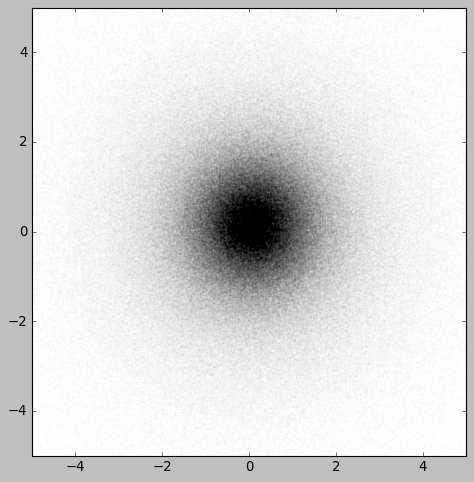

In [4]:
fig, ax = plt.subplots(1, 1 ,figsize=(7,7), sharey=True)
ax.scatter(s.data['pos'][:,0], s.data['pos'][:,1], s=0.1, alpha=0.01)
ax.set(xlim=(-5,5), ylim=(-5,5))

In [5]:
def plummer_dens(r, rc):
  m = 1e11
  return 3*m/(4*np.pi*rc**3) * (1 + r**2/rc**2)**(-5/2)

dr set to 0.658578
Calculation took 0.00967s


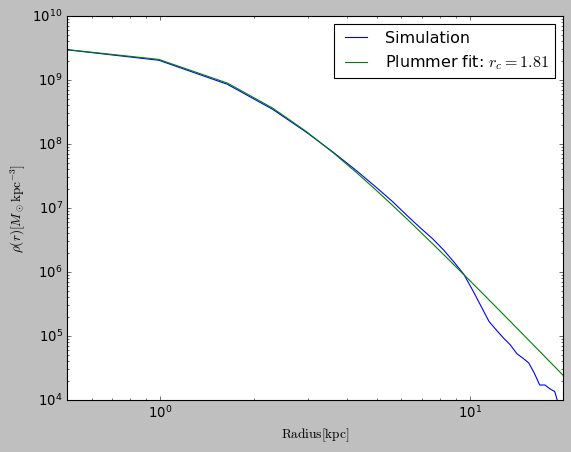

In [6]:
dens_prof = s.get_raddens(center=[0,0,0])
plt.loglog(dens_prof[1,:], dens_prof[0,:], label='Simulation')
from scipy.optimize import curve_fit

popt, pcov = curve_fit(plummer_dens, dens_prof[1,:], dens_prof[0,:])
rc_fit = popt[0]
plt.loglog(dens_prof[1,:], plummer_dens(dens_prof[1,:], rc_fit), label=r'Plummer fit: $r_c={:.2f}$'.format(rc_fit))
plt.xlim(5e-1, 2e1)
plt.ylim(1e4, 1e10)
plt.legend()
plt.xlabel(r'$\mathrm{Radius} [\mathrm{kpc}]$')
plt.ylabel(r'$\rho (r) [ M_\odot \mathrm{kpc}^{-3}]$')
plt.savefig('Plummer_fit.pdf')

In [13]:
s.data['l1'] = s.data['tijl'][:,0] * (gyr /(s.UnitLength_in_cm/s.UnitVelocity_in_cm_per_s))**2 * s.hubbleparam**2/ s.time**3
s.data['l2'] = s.data['tijl'][:,1] * (gyr /(s.UnitLength_in_cm/s.UnitVelocity_in_cm_per_s))**2 * s.hubbleparam**2/ s.time**3
s.data['l3'] = s.data['tijl'][:,2] * (gyr /(s.UnitLength_in_cm/s.UnitVelocity_in_cm_per_s))**2 * s.hubbleparam**2/ s.time**3

s.data['T_str'] = s.data['l1'] + 1/3 * np.abs(s.data['l1'] + s.data['l2'] + s.data['l3'])
# s.data['T_str'] = s.data['l1'] -1/2*(s.data['l2'] + s.data['l3'])
# s.data['T_str'] = np.maximum( np.absolute(s.data['l1']), np.maximum(np.absolute(s.data['l2']), np.absolute(s.data['l3'])))

In [9]:
r = np.logspace(np.log10(0.1), np.log10(20), 50)
kde = gaussian_kde([s.data['r'], s.data['l1']])

r_grid, l1_grid = np.meshgrid(r, np.linspace((s.data['l1']).min(), (s.data['l1']).max(), 50))
z = kde(np.vstack([r_grid.ravel(), l1_grid.ravel()]))

In [9]:
idx = np.digitize(s.data['r'], r)
medianvalue = [np.median(s.data['l1'][idx==k]) for k in range(50)]
delta = (r[1] - r[0])
std_value = [(s.data['l1'])[idx==k].std() for k in range(50)]

In [10]:
Trr = -1*G*Mplummer*(rc_fit**2 - 2*r**2)/((r**2 + rc_fit**2)**(5/2))
Trr *= gyr**2 / kpc**3

Tphiphi = -1*G*Mplummer/((r**2 + rc_fit**2)**(3/2))
Tphiphi *= gyr**2 / kpc**3

# Tstr = G*Mplummer*(r/rc_fit)**2 / (rc_fit**3 * (1 + (r/rc_fit)**2)**(5/2))
# Tstr *= gyr**2 / kpc**3
Tstr = Trr - Tphiphi

(-80000.0, 25000.0)

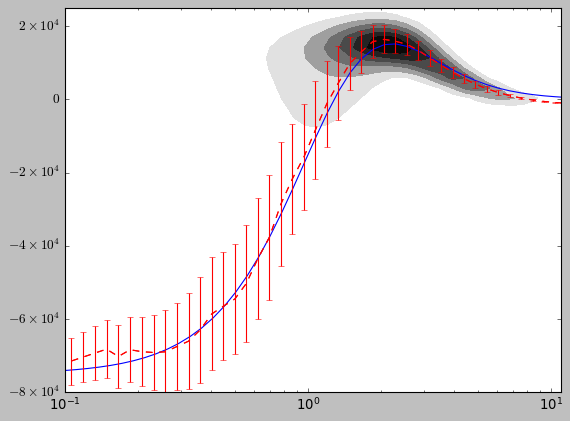

In [11]:
fig = plt.figure()
ax = fig.add_subplot()
ax.contourf(r_grid, l1_grid, z.reshape(r_grid.shape), cmap='Greys', norm='log')
ax.plot(r, Trr)
ax.plot(r - delta/2, medianvalue, 'r--')
ax.errorbar(r - delta/2, medianvalue, std_value, fmt='r--')
ax.set_xscale('log')
ax.set_yticks([-8e4, -6e4, -4e4, -2e4, 0, 2e4], labels=[r"$-8\times10^4$", r"$-6\times10^4$", r"$-4\times10^4$", r"$-2\times10^4$", r'$0$', r"$2\times10^4$"] )
ax.set_xlim(1e-1, 1.1e1)
ax.set_ylim(-8e4, 25000)

In [12]:
# marta_r, marta_T = np.loadtxt('/home/pdcg/Downloads/marta_line.csv', unpack=True, delimiter=',')

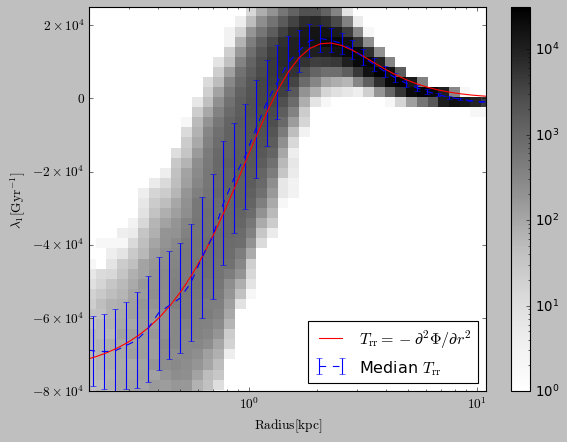

In [13]:
fig = plt.figure()
ax = fig.add_subplot()
h = ax.hist2d(s.data['r'], s.data['l1'], bins=(r, np.linspace((s.data['l1']).min(), (s.data['l1']).max(), 50)), cmap='Greys', norm='log')
# ax.scatter(s.data['r'], -s.data['l1'], s=0.1, alpha=0.1)
# ax.plot(r - delta/2, medianvalue, c='orange', linestyle='--', label='Median')
ax.errorbar(r - delta/2, medianvalue, std_value, fmt='b--', label=r'Median $T_\mathrm{rr}$')
# ax.plot(marta_r, -marta_T, c='r', label='Reina-Campos 22')
ax.plot(r, Trr, c='r', label=r'$T_\mathrm{rr} =  -\partial^2 \Phi / \partial r^2$')
ax.set_xscale('log')
# ax.set_yscale('symlog')
ax.set_xticks([1e0, 1e1], labels=[r"$10^0$", r"$10^1$"] )
ax.set_yticks([-8e4, -6e4, -4e4, -2e4, 0, 2e4], labels=[r"$-8\times10^4$", r"$-6\times10^4$", r"$-4\times10^4$", r"$-2\times10^4$", r'$0$', r"$2\times10^4$"] )
ax.set_xlim(2e-1, 1.1e1)
ax.set_ylim(-8e4, 25000)
ax.set_xlabel(r'$\mathrm{Radius} [\mathrm{kpc}]$')
ax.set_ylabel(r'$\lambda_1 [\mathrm{Gyr}^{-1}]$')
ax.legend(loc=0)
fig.colorbar(h[3], ax=ax)
fig.savefig('plummer_test.pdf')

(-80000.0, 60000.0)

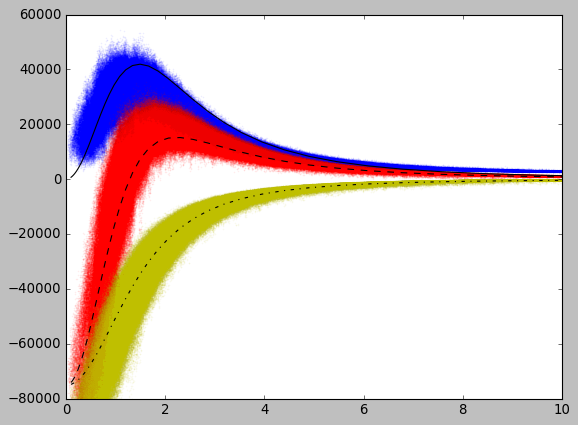

In [14]:
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(s.data['r'], s.data['T_str'] + 2000, s=0.1, alpha=0.1, c='b', edgecolors='b')
ax.scatter(s.data['r'], s.data['l1'] + 2000, s=0.1, alpha=0.1, c='r', edgecolors='r')
ax.scatter(s.data['r'], .5*(s.data['l2'] + s.data['l3']) + 2000, s=0.1, alpha=0.1, c='y', edgecolors='y')
ax.plot(r, Trr, 'k--')
ax.plot(r, Tphiphi, 'k-.')
ax.plot(r, Tstr, 'k')
ax.set_xlim(0,10)
ax.set_ylim(-80000, 60000)